In [1]:
# Is an ARIMA(2,1,2) model suitable for the bandwidth dataset ?

# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("data/bandwidth.csv")
df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


In [3]:
print(df['hourly_bandwidth'].describe())

count    10000.000000
mean      1232.634448
std        615.204936
min        193.079868
25%        751.099777
50%       1064.494357
75%       1896.875640
max       2402.361236
Name: hourly_bandwidth, dtype: float64


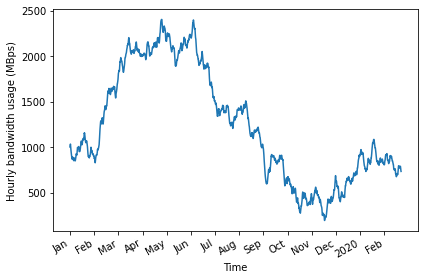

In [4]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth usage (MBps)')

plt.xticks(np.arange(0, 10000, 730), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [5]:
# Test for stationerity using agugented Dickey Fuller algorithm
adf_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic :{adf_result[0]}')
print(f'P-value :{adf_result[1]}')

ADF Statistic :-0.8714653199451774
P-value :0.7972240255014857


In [6]:
# The process is not statitionery, so we apply differentiation to make it stationery
df_diff = np.diff(df['hourly_bandwidth'])

In [7]:
# Test for stationerity using agugented Dickey Fuller algorithm
adf_result = adfuller(df_diff)

print(f'ADF Statistic:{adf_result[0]}')
print(f'P-value:{adf_result[1]}')

ADF Statistic:-20.694853863789035
P-value:0.0


In [8]:
# We have a p-value smaller than 0.05 and a large negative ADF statistic, our series is stationary
# d = 1 (Number of rounds of differencing to make our data stationery)
d = 1

In [9]:
# Next we separate our data into train and test sets. 
# For model fitting, we will reserve 168 for test data and leave the rest for training data

train = df['hourly_bandwidth'][:-168].copy()
test = df['hourly_bandwidth'][-168:].copy()

print(len(train))
print(len(test))

9832
168


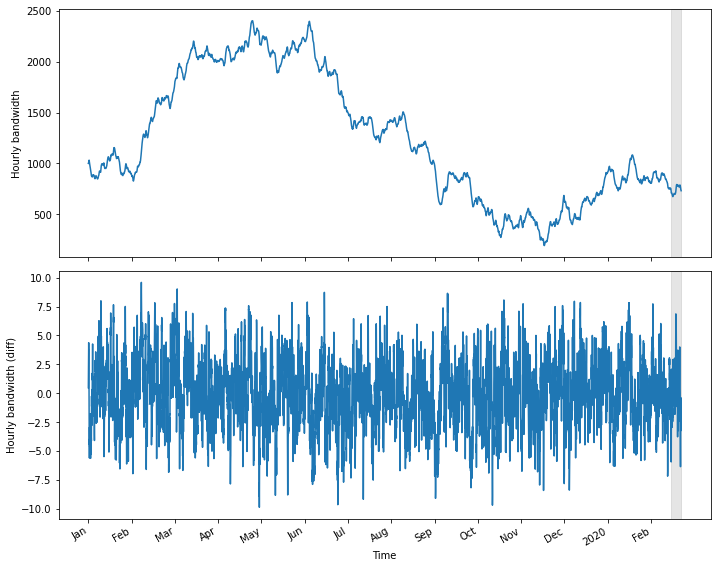

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth')
ax1.axvspan(9831, 10000, color="#808080", alpha=0.2)

ax2.plot(df_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth (diff)')
ax2.axvspan(9830, 9999, color="#808080", alpha=0.2)

plt.xticks(np.arange(0, 10000, 730), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [11]:
# use optimize_ARIMA function to fit the many ARIMA(p,d,q) models

from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    results = []

    # Iterate over each unique (p,q) combination. The use of tqdm_notebook will display a progress bar
    for order in tqdm(order_list):
        try:
            # Fit an ARIMA(p,d,q) model using the SARIMAX function.
            # We specify simple_differencing=False, to prevent differencing.
            # We also specify disp=False to avoid printing convergence messages to the console
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [12]:
# We define a list of possible values for the orders p and q.

from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)
order_list = list(product(ps, qs))

In [13]:
# Run the optimize_ARIMA function to obtain the model with the lowest AIC.
import warnings
warnings.filterwarnings('ignore')

result_df = optimize_ARIMA(train, order_list, d)
result_df

,"(p,d,q)",AIC
0,"(3, 2)",27991.063157
1,"(2, 3)",27991.286794
2,"(2, 2)",27991.602936
3,"(3, 3)",27993.416226
4,"(1, 3)",28003.348864
5,"(1, 2)",28051.350913
6,"(3, 1)",28071.155049
7,"(3, 0)",28095.617602
8,"(2, 1)",28097.250206
9,"(2, 0)",28098.407146


In [14]:
# From the returned DataFrame, an ARIMA(3,1,2) model seems to be the most suitable, so fit it on the training set
# The expected ARIMA(2, 1, 2) model was third, however its AIC value is very close to the first one, 
# albeit with fewer terms i.e. 4 rather 5. I will therefore use ARIMA(2, 1, 2)

model = SARIMAX(train, order=(2,d,2), simple_differencing=False)
model_fit = model.fit(disp = False)
residuals = model_fit.resid

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       hourly_bandwidth   No. Observations:                 9832
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -13990.801
Date:                Fri, 29 Sep 2023   AIC                          27991.603
Time:                        11:05:33   BIC                          28027.569
Sample:                             0   HQIC                         28003.788
                               - 9832                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

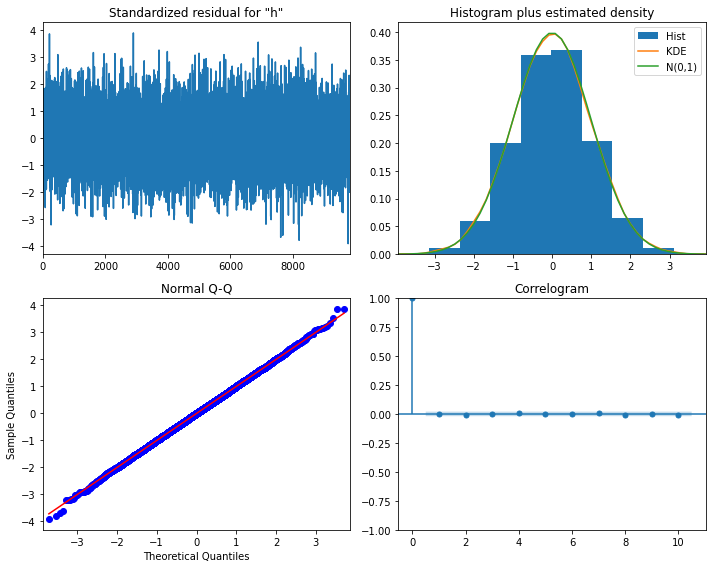

In [15]:
model_fit.plot_diagnostics(figsize=(10,8))

plt.tight_layout()

In [16]:
# From the the top-left plot, the variance is not constant, which is a discrepancy in comparison to white noise. 
# At the top right is the distribution of the residuals, we can see what is close to a normal distribution. 
# The Q-Q plot displays a line that is fairly straight, meaning that the residuals’ distribution is close to a normal distribution. 
# Finally, the correlogram at the bottom right, shows no significant coefficients after lag 0, just like white noise.

# Thus, from a qualitative standpoint, it seems that our residuals are close to white noise, which is a good sign, 
# as it means that the model’s errors are random.

In [17]:
# Finally apply the Ljung-Box test to quantitatively assess whether our residuals are indeed uncorrelated.
from statsmodels.stats.diagnostic import acorr_ljungbox

lbvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)
lbvalue.columns= ['stat', 'p-value']
lbvalue

,stat,p-value
1,0.001923,0.965020
2,0.005134,0.997436
3,0.025881,0.998901
4,0.025943,0.999917
5,0.026603,0.999994
6,0.049674,0.999997
7,0.057616,1.000000
8,0.060490,1.000000
9,0.063568,1.000000
10,0.065937,1.000000


In [18]:
# p-values are all greater than 0.05, so the residuals are NOT correlated just like white noise.
# As a benchmark for our model, we use the mean & last value. 

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
    
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,1,2))
            
            res = model.fit(disp=False)            
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
        return pred_ARIMA

In [20]:
test = pd.DataFrame(test)
test.columns = ['hourly_bandwidth']
test.head()

,hourly_bandwidth
9832,717.176939
9833,711.311745
9834,708.114679
9835,707.024482
9836,707.689774


In [21]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_ARIMA'] = pred_ARIMA

test.head()

,hourly_bandwidth,pred_mean,pred_last_value,pred_ARIMA
9832,717.176939,1241.072644,723.120934,717.660272
9833,711.311745,1241.072644,723.120934,712.769646
9834,708.114679,1240.965500,711.311745,705.975840
9835,707.024482,1240.965500,711.311745,701.224109
9836,707.689774,1240.857042,707.024482,706.648886


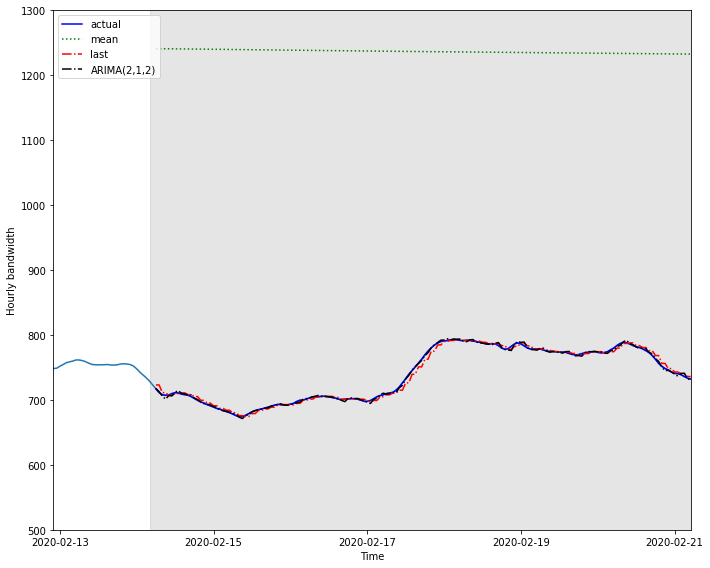

In [22]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(df['hourly_bandwidth'])
ax.plot(test['hourly_bandwidth'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARIMA'], 'k-.', label='ARIMA(2,1,2)')
ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth')

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)  #Zoom in on the testing period
ax.set_ylim(500, 1300)

plt.xticks([9802, 9850, 9898, 9946, 9994], ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])
fig.autofmt_xdate
plt.tight_layout()

In [23]:
# Quantify error using the mean Absolute Error (MAE)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)) 

In [24]:
mae_mean = mae(test['hourly_bandwidth'], test['pred_mean'])
mae_last = mae(test['hourly_bandwidth'], test['pred_last_value'])
mae_ARIMA = mae(test['hourly_bandwidth'], test['pred_ARIMA'])

print(mae_mean, mae_last, mae_ARIMA)

497.9274198118277 2.8444991498767638 1.3844224599363497


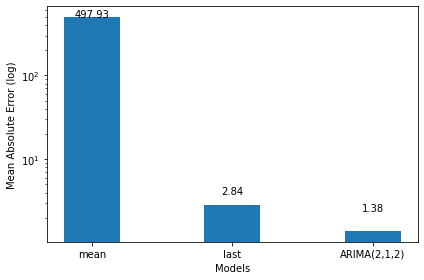

In [25]:
fig, ax = plt.subplots()

x = ['mean', 'last', 'ARIMA(2,1,2)']
y = [mae_mean, mae_last, mae_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('Mean Absolute Error (log)')
plt.yscale('log')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

In [26]:
# ARIMA(2,1,2) has a better(lower) Mean Absolute Error than the ARMA(14.00) for the same bandwidth dataset

In [27]:
# record end time

end = dt.now()
elapsed = end -start

print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:08:50
